# Preprocess APO fluxes from CarboScope inversion

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

import cftime

import pandas as pd
import xarray as xr
import intake

import config
import regrid_tools
import util

## Read APO flux data

In [3]:
cat = intake.open_catalog("catalogs/fluxes-catalog-web.yml")
cat

fluxes-catalog-web:
  args:
    path: catalogs/fluxes-catalog-web.yml
  description: Flux datasets
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [4]:
version = "apo99X_v2021"

### Fix `storage_options` to increase `timeout` 

In [5]:
import aiohttp
timeout = aiohttp.ClientTimeout(total=86400)
storage_options=dict(**cat[f"fgapo_CarbonScope_{version}"].storage_options)
storage_options.update(
    dict(
        http=dict(client_kwargs={'timeout': timeout}),
    )
)
storage_options

{'simplecache': {'same_names': True,
  'cache_storage': '/glade/work/mclong/sno-analysis/intake-cache'},
 'http': {'client_kwargs': {'timeout': ClientTimeout(total=86400, connect=None, sock_read=None, sock_connect=None)}}}

In [6]:
ds = cat[f"fgapo_CarbonScope_{version}"](storage_options=storage_options).to_dask().compute()            
ds

<xarray.Dataset>
Dimensions:        (lon: 144, nv: 2, lat: 90, itime: 11688, proc: 8, rt: 3, spec: 1, mtime: 8036, mtime0: 100)
Coordinates:
  * lon            (lon) float32 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat            (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * itime          (itime) int32 -315532800 -315446400 ... 694137600 694224000
  * proc           (proc) int32 1 2 3 4 5 6 7 8
  * rt             (rt) int32 1 2 3
  * spec           (spec) int32 1
  * mtime          (mtime) int32 -31492801 -31406401 ... 662644800 662731200
Dimensions without coordinates: nv, mtime0
Data variables: (12/22)
    lon_bounds     (lon, nv) float32 -180.0 -177.5 -177.5 ... 177.5 177.5 180.0
    lat_bounds     (lat, nv) float32 -90.0 -88.0 -88.0 -86.0 ... 88.0 88.0 90.0
    itime_bounds   (itime, nv) int32 -315532800 -315446400 ... 694310400
    dt             (itime) int32 86400 86400 86400 86400 ... 86400 86400 86400
    year           (itime) float64 1.99e+03 1.99e+03 ... 2.022e+03 2.022e+03
    lproc          (proc) |S20 b'fosLnd              ' ... b'ini             ...
    ...             ...
    myear2         (mtime) float64 1.999e+03 1.999e+03 ... 2.021e+03 2.021e+03
    tmask          (mtime0, itime) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    apoflux_land   (mtime, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    apoflux_ocean  (mtime, lat, lon) float32 0.0 0.0 0.0 ... 0.004139 0.004139
    apoflux_subt   (mtime, lat, lon) float32 0.0 0.0 ... -0.0002619 -0.0002617
    apoflux_excl   (mtime, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/19)
    title:                 Jena CarboScope results
    history:               Inversion code by Christian Roedenbeck
    institution:           MPI Biogeochemistry Jena
    references:            http://www.BGC-Jena.mpg.de/CarboScope/
    Conventions:           CF-1.1
    species:               apo
    ...                    ...
    normalization_period:  1999-2020 (inclusive)
    yrni:                  1999
    yrne:                  2020
    dirname:               OUTPUT13.049+tm3_ncep_fg.1990-2021_2Hx2.apo.-S-COM...
    filename:              mu1.0_120_flux_asis+YRVI-YRVE.nc
    c0:                    -18.0

In [7]:
ds.apoflux_ocean.attrs

{'long_name': 'Ocean-atmosphere apo flux',
 'units': 'Tmol/yr',
 'cell_methods': 'lon: lat: sum',
 'cell_measures': 'area: dxyp'}

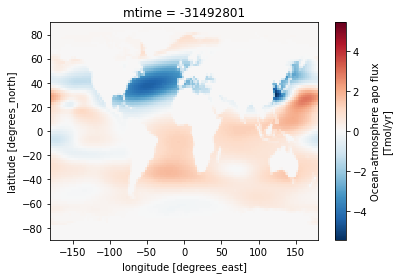

In [8]:
ds.apoflux_ocean.isel(mtime=0).plot()

In [9]:
grid = util.generate_latlon_grid(nx=ds.lon.size, ny=ds.lat.size, lon0=-180.)
np.testing.assert_array_almost_equal(grid.lon.values, ds.lon.values)
np.testing.assert_array_almost_equal(grid.lat.values, ds.lat.values)

src_grid = regrid_tools.grid("latlon", nx=ds.lon.size, ny=ds.lat.size, lon0=-180.)
src_grid

exists: /glade/scratch/mclong/tmp/regridding/latlon_2.5x2.0_lon0=-180.0.nc


grid: latlon_latlon_2.5x2.0_lon0=-180.0
dims: (90, 144)
file: /glade/scratch/mclong/tmp/regridding/latlon_2.5x2.0_lon0=-180.0.nc

In [10]:
dt = ds.dt.values[0]
np.testing.assert_equal(ds.dt.values, dt)

assert ds.apoflux_ocean.units == 'Tmol/yr'

In [11]:
Tmolyr_to_mols = 1e12 / 365. / 86400.
flux_variables = dict(
    SFAPO_OCN="apoflux_ocean",
    SFAPO_LND="apoflux_land",
    SFAPO_FF="apoflux_subt",
    SFAPO_EXC="apoflux_excl",
)
dso_src = ds[["mtime", "lat", "lon"]]
for var_out, var_in in flux_variables.items():    
    dso_src[var_out] = ds[var_in] / ds.dxyp * Tmolyr_to_mols
    dso_src[var_out].attrs = ds[var_in].attrs
    dso_src[var_out].attrs["units"] = "mol/m^2/s"
    del dso_src[var_out].attrs["cell_measures"]
    dso_src[var_out].encoding = ds[var_in].encoding
    

In [12]:
mtime = cftime.num2date(ds.mtime, ds.mtime.units)
time, time_bnds = util.gen_daily_cftime_coord((mtime[0].year, mtime[-1].year))

assert len(time) == len(mtime)

In [13]:
dst_grid = regrid_tools.grid("latlon", **config.config_dict["flux-dst-grid-kwargs"])
dst_grid

exists: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc


grid: latlon_latlon_1.0x1.0_lon0=-180.0
dims: (180, 360)
file: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc

In [14]:
regrid_obj = regrid_tools.regridder(src_grid, dst_grid, method="conserve", clobber=False)
regrid_obj

source grid dims: (90, 144)
destination grid dims: (180, 360)


regridder latlon_2.5x2.0_lon0=-180.0.nc --> latlon_1.0x1.0_lon0=-180.0.nc

In [15]:
dso = util.generate_latlon_grid(**config.config_dict["flux-dst-grid-kwargs"])[["area"]]

dso_dst_data = regrid_obj(dso_src[flux_variables.keys()])
dso['time'] = time
dso['time_bnd'] = time_bnds

for v in dso_dst_data.data_vars:
    dso[v] = dso_dst_data[v]
    dso[v].encoding = dso_src[v].encoding
    
time = cftime.num2date(dso.time, units=dso.time.attrs["units"])    
dso

AttributeError: 'Dataset' object has no attribute 'time'

In [ ]:
file_out = f"{config.flux_product_dir}/SFAPO.CarboScope.{version}.nc"

ds.attrs.update({k: ds.attrs[k] for k in ['history', 'title', 'institution', 'references']})
util.to_netcdf_clean(dso, file_out, format='NETCDF4')

In [ ]:
curator = util.curate_flux_products()
curator.add_source(
        key=f"SFAPO.carboscope.{version}",
        urlpath=file_out,
        description=f'APO fluxes from CarboScope inversion {version}',
    )